In [3]:
# %pip install datasets
# %pip install Pillow
# %pip install numpy
# %pip install matplotlib
# %pip install import_ipynb
# %pip install tensorflow
# %pip install tensorflow.keras
# %pip install easyocr
# %pip install pandas

# # library from etl
# %pip install datasets
# %pip install numpy
# %pip install Pillow
# %pip install opencv-python
# %pip install json

In [4]:
import easyocr
import matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
# from tensorflow.keras import layers
import json
import pandas as pd

In [5]:
from kaggle_secrets import UserSecretsClient
import os

# Ambil GitHub token dari Kaggle Secrets
user_secrets = UserSecretsClient()
myGithub = user_secrets.get_secret("githubKey")

# Clone repo GitHub
!git clone https://{myGithub}@github.com/fitristachan/invoice-image-processing.git invoice_image_processing
!git -C invoice_image_processing pull

Cloning into 'invoice_image_processing'...
remote: Enumerating objects: 1699, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 1699 (delta 22), reused 17 (delta 12), pack-reused 1659 (from 2)
Receiving objects: 100% (1699/1699), 309.13 MiB | 43.22 MiB/s, done.
Resolving deltas: 100% (314/314), done.
Updating files: 100% (1298/1298), done.
Already up to date.


In [6]:
# from google.colab import userdata

# # Retrieve the GitHub token from userdata
# myGithub = userdata.get('githubKey')

# !git clone https://{myGithub}@github.com/fitristachan/invoice-image-processing.git /content/invoice_image_processing
# !git -C invoice_image_processing pull



In [7]:
# import sys
# import os

# sys.path.append('/content/invoice-image-processing')
# print(os.listdir('/content/invoice-image-processing'))

# !jupyter nbconvert --to script '/content/invoice-image-processing/data_etl_invoice.ipynb' --output data_etl

Image Classification

In [8]:
from invoice_image_processing.data_etl import DatasetReceipt

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [9]:
from keras.applications import ResNet50V2

# keras.applications.ResNet50V2(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
#     name="resnet50v2",
# )

pre_trained_model = ResNet50V2(input_shape = (600, 600, 3),
                                include_top = False,
                                pooling='max'
                                )

pre_trained_model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 600, 600, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 606, 606, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 300, 300, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 302, 302, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 150, 150, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 150, 150, 64)   │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 150, 150, 64)   │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 150, 150, 64)   │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 150, 150, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 150, 150, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 152, 152, 64)   │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 150, 150, 64)   │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 150, 150, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 150, 150, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 150, 150, 256)  │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [10]:
from datasets import concatenate_datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from typing import List

# Load individual datasets
train_cord = DatasetReceipt("naver-clova-ix/cord-v2", "train")
val_cord = DatasetReceipt("naver-clova-ix/cord-v2", "validation")
train_donut = DatasetReceipt("katanaml-org/invoices-donut-data-v1", "train")
val_donut = DatasetReceipt("katanaml-org/invoices-donut-data-v1", "validation")

class CombinedReceiptDataset(Dataset):
    def __init__(self, datasets: List[DatasetReceipt]):
        self.samples = []
        for d in datasets:
            self.samples.extend([d[i] for i in range(len(d))])  # langsung ambil hasil akhir dari DatasetReceipt

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        img = sample["image"]
        # if img.dtype != np.float32:
        #     img = img.astype(np.float32) / 255.0  # normalisasi jika belum

        return {
            "image": torch.tensor(img, dtype=torch.float32),
            "quantities": sample["quantities"],  # tetap list of strings
            "prices": sample["prices"],          # tetap list of strings
            "total_price": sample["total_price"],# tetap string
            "item_names": sample["item_names"],  # tetap list of strings
        }

train_dataset = CombinedReceiptDataset([train_cord, train_donut])
val_dataset = CombinedReceiptDataset([val_cord, val_donut])

# Verifikasi
sample = train_dataset[0]
print(f"Image shape: {sample['image'].shape}")  # Harusnya [3, 600, 600]
print(f"Image type: {type(sample['image'])}")  # torch.Tensor

print(f"Total data train CORD: {len(train_cord)}")
print(f"Total data train Donut: {len(train_donut)}")
print(f"Total data train: {len(train_dataset)}")
print(f"Total data validasi: {len(val_dataset)}")

# Verifikasi jumlah harus sama dengan penjumlahan
assert len(train_dataset) == len(train_cord) + len(train_donut), "Jumlah data tidak sesuai!"

README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

(…)-00000-of-00004-b4aaeceff1d90ecb.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00001-of-00004-7dbbe248962764c5.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

(…)-00002-of-00004-688fe1305a55e5cc.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

(…)-00003-of-00004-2d0cd200555ed7fd.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

(…)-00000-of-00001-cc3c5779fe22e8ca.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

(…)-00000-of-00001-9c204eb3f4e11791.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

(…)-00000-of-00001-a5c51039eab2980a.parquet:   0%|          | 0.00/167M [00:00<?, ?B/s]

(…)-00000-of-00001-b8a5c4a6237baf25.parquet:   0%|          | 0.00/19.9M [00:00<?, ?B/s]

(…)-00000-of-00001-56af6bd5ff7eb34d.parquet:   0%|          | 0.00/10.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/425 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/26 [00:00<?, ? examples/s]

Image shape: torch.Size([600, 600, 3])
Image type: <class 'torch.Tensor'>
Total data train CORD: 800
Total data train Donut: 425
Total data train: 1225
Total data validasi: 150


In [11]:
# # # Inisialisasi dataset dengan ukuran yang diinginkan (600x600) KALO CPU
# # train_cord = DatasetReceipt("naver-clova-ix/cord-v2", "train", image_size=(600, 600))
# # val_cord = DatasetReceipt("naver-clova-ix/cord-v2", "validation", image_size=(600, 600))

# # class HWC_DatasetWrapper:
# #     def __init__(self, dataset):
# #         self.dataset = dataset
    
# #     def __len__(self):
# #         return len(self.dataset)
    
# #     def __getitem__(self, idx):
# #         sample = self.dataset[idx]
# #         sample['image'] = sample['image'].transpose(1, 2, 0)  # CHW → HWC
# #         return sample

# # # Gunakan wrapper
# # train_dataset = HWC_DatasetWrapper(train_cord)
# # val_dataset = HWC_DatasetWrapper(val_cord)

# # # Verifikasi
# # sample = train_dataset[0]
# # print(sample['image'].shape)  # Output: (600, 600, 3)

# train_cord = DatasetReceipt("naver-clova-ix/cord-v2", "train", image_size=(600, 600))
# val_cord = DatasetReceipt("naver-clova-ix/cord-v2", "validation", image_size=(600, 600))

# train_dataset = train_cord
# val_dataset = val_cord

# # Verifikasi
# sample = train_dataset[0]
# print(sample['image'].shape)  # Output: (600, 600, 3)

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd

def dataset_generator(dataset, batch_size=16, max_items=10, max_name_length=20, vocab_size=128):
    while True:
        batch_types = []  # Saran 4: Tambahkan fitur pembeda receipt/invoice
        batch_images = []
        batch_names = []
        batch_quantities = []
        batch_prices = []
        batch_totals = []

        for _ in range(batch_size):
            sample = dataset[np.random.randint(len(dataset))]
            img = sample["image"]

            # Augmentasi aman untuk dokumen
            img = tf.convert_to_tensor(img, dtype=tf.float32)
            img = tf.image.random_brightness(img, max_delta=0.05)
            img = tf.image.random_contrast(img, lower=0.95, upper=1.05)
            img = img.numpy()

            batch_images.append(img)
            
            # Saran 4: Deteksi jenis dokumen (0 untuk invoice, 1 untuk receipt)
            doc_type = 0  # Default receipt
            if "donut" in sample.get("doc_type", "").lower():
                doc_type = 0
            batch_types.append(doc_type)

            # Inisialisasi padding
            padded_names = np.zeros((max_items, max_name_length), dtype=np.int32)
            padded_quantities = np.zeros(max_items, dtype=np.float32)  # Saran 5: Ubah ke float untuk regresi
            padded_prices = np.zeros(max_items, dtype=np.float32)      # Saran 5: Ubah ke float untuk regresi
            padded_total = np.zeros(1, dtype=np.float32)               # Saran 5: Ubah ke float untuk regresi

            if "item_names" in sample and len(sample["item_names"]) > 0:
                item_names = sample["item_names"]
                quantities = sample.get("quantities", ["0"] * len(item_names))
                prices = sample.get("prices", ["0"] * len(item_names))
                total_price = sample.get("total_price", "0")

                n_items = min(len(item_names), max_items)

                # Saran 5: Konversi quantity dan price ke nilai numerik
                for i in range(n_items):
                    name = str(item_names[i])[:max_name_length]
                    name_token = [ord(c) % vocab_size for c in name]
                    padded_names[i, :len(name_token)] = name_token
                    
                    try:
                        padded_quantities[i] = float(quantities[i]) if quantities[i] else 0.0
                        padded_prices[i] = float(prices[i]) if prices[i] else 0.0
                    except (ValueError, TypeError):
                        padded_quantities[i] = 0.0
                        padded_prices[i] = 0.0

                # Saran 5: Konversi total_price ke numerik
                try:
                    padded_total[0] = float(total_price) if total_price else 0.0
                except (ValueError, TypeError):
                    padded_total[0] = 0.0

            batch_names.append(padded_names)
            batch_quantities.append(padded_quantities)
            batch_prices.append(padded_prices)
            batch_totals.append(padded_total)

        # Convert ke numpy
        batch_images = np.array(batch_images, dtype=np.float32)
        batch_types = np.array(batch_types, dtype=np.float32)
        batch_names = to_categorical(batch_names, num_classes=vocab_size)
        batch_quantities = np.array(batch_quantities, dtype=np.float32)
        batch_prices = np.array(batch_prices, dtype=np.float32)
        batch_totals = np.array(batch_totals, dtype=np.float32)

        # Saran 4 & 5: Sesuaikan output untuk model multi-input
        yield (
            {
                "image_input": batch_images,
                "type_input": batch_types  # Saran 4
            },
            {
                "item_name": batch_names,
                "quantity_final": batch_quantities,  # Saran 5: sekarang numerik
                "price_final": batch_prices,         # Saran 5: sekarang numerik
                "total_price": batch_totals    # Saran 5: sekarang numerik
            }
        )

# Saran 5: Contoh arsitektur model yang sesuai
def build_model(vocab_size, max_items=10, max_name_length=20):
    # Input layer
    image_input = Input(shape=(None, None, 3), name="image_input")  # Flexible size
    type_input = Input(shape=(1,), name="type_input")  # Saran 4
    
    # Backbone CNN
    backbone = ResNet50V2(weights=None, include_top=False)(image_input)
    features = GlobalAveragePooling2D()(backbone)
    
    # Gabungkan dengan jenis dokumen (Saran 4)
    merged = Concatenate()([features, type_input])
    
    # Output layers
    item_name_output = Dense(max_items * max_name_length * vocab_size, activation="softmax", name="item_name")(merged)
    quantity_output = Dense(max_items, name="quantity_final")(merged)  # Saran 5: regresi
    price_output = Dense(max_items, name="price_final")(merged)       # Saran 5: regresi
    total_price_output = Dense(1, name="total_price")(merged)   # Saran 5: regresi
    
    return Model(
        inputs=[image_input, type_input],
        outputs=[item_name_output, quantity_output, price_output, total_price_output]
    )

In [13]:
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50V2
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import to_categorical
# import numpy as np
# import pandas as pd

# def dataset_generator(dataset, batch_size=16, max_items=10, max_name_length=20, vocab_size=128):
#     while True:
#         batch_images = []
#         batch_names = []
#         batch_quantities = []
#         batch_prices = []
#         batch_totals = []

#         for _ in range(batch_size):
#             sample = dataset[np.random.randint(len(dataset))]
            
#             img = sample["image"]
#             if img.ndim == 4 and img.shape[0] == 1:
#                 img = img[0]
#             batch_images.append(img)

#             padded_names = np.zeros((max_items, max_name_length), dtype=np.int32)
#             padded_quantities = np.zeros((max_items, max_name_length), dtype=np.int32)
#             padded_prices = np.zeros((max_items, max_name_length), dtype=np.int32)
#             padded_total = np.zeros(max_name_length, dtype=np.int32)

#             if "item_names" in sample and len(sample["item_names"]) > 0:
#                 item_names = sample["item_names"]
#                 quantities = sample.get("quantities", ["0"] * len(item_names))
#                 prices = sample.get("prices", ["0"] * len(item_names))
#                 total_price = sample.get("total_price", "0")

#                 # Cast to string first
#                 quantities = [str(q) for q in quantities]
#                 prices = [str(p) for p in prices]
#                 total_price = str(total_price)

#                 n_items = min(len(item_names), max_items)

#                 for i in range(n_items):
#                     name = str(item_names[i])[:max_name_length]
#                     quantity = quantities[i][:max_name_length]
#                     price = prices[i][:max_name_length]

#                     name_token = [ord(c) % vocab_size for c in name]
#                     qty_token = [ord(c) % vocab_size for c in quantity]
#                     price_token = [ord(c) % vocab_size for c in price]

#                     padded_names[i, :len(name_token)] = name_token
#                     padded_quantities[i, :len(qty_token)] = qty_token
#                     padded_prices[i, :len(price_token)] = price_token

#                 # Total price
#                 total_token = [ord(c) % vocab_size for c in total_price[:max_name_length]]
#                 padded_total[:len(total_token)] = total_token

#             batch_names.append(padded_names)
#             batch_quantities.append(padded_quantities)
#             batch_prices.append(padded_prices)
#             batch_totals.append(padded_total)

#         # Convert to numpy arrays
#         batch_images = np.array(batch_images, dtype=np.float32)
        
#         # Only item_name is categorical (sequence of one-hot)
#         batch_names = to_categorical(batch_names, num_classes=vocab_size)
        
#         # The others are numeric regression targets
#         batch_quantities = np.array(batch_quantities, dtype=np.float32)[:, :, 0]
#         batch_prices = np.array(batch_prices, dtype=np.float32)[:, :, 0]
#         batch_totals = np.array(batch_totals, dtype=np.float32)[:, 0]


#         # # Optional: one-hot encode
#         # batch_names = to_categorical(batch_names, num_classes=vocab_size)
#         # batch_quantities = to_categorical(batch_quantities, num_classes=vocab_size)
#         # batch_prices = to_categorical(batch_prices, num_classes=vocab_size)
#         # batch_totals = to_categorical(batch_totals, num_classes=vocab_size)

#         yield (batch_images, {
#             "item_name": batch_names,
#             "quantity": batch_quantities,
#             "price": batch_prices,
#             "total_price": batch_totals
#         })

 

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Lambda, LSTM, Dense, TimeDistributed, 
                                    RepeatVector, Concatenate, Input)
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
import tensorflow as tf

# Constants
NUM_CHAR_CLASSES = 122
STEPS_PER_EPOCH = 1000
EPOCH = 25
INITIAL_LR = 1e-4
MOMENTUM = 0.9
GRADIENT_CLIP_NORM = 1.0
STD_DEV = 0.01

# 1. Input Layers
image_input = Input(shape=(600, 600, 3), name="image_input")
doc_type_input = Input(shape=(1,), name="type_input")  # Suggestion 4

# 2. Base Model
base_model = ResNet50V2(
    input_shape=(600, 600, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
base_model.trainable = False
image_features = base_model(image_input)

# 3. Combine with document type (Suggestion 4)
combined = Concatenate()([image_features, doc_type_input])

# 4. Custom Head
x = Dense(512, activation='relu', 
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=STD_DEV))(combined)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', 
          kernel_regularizer=regularizers.l2(0.01))(x)

# 5. Numeric Outputs (Suggestion 5)
quantity_output = Dense(10, activation='linear', name='quantity')(x)
price_output = Dense(10, activation='linear', name='price')(x)
total_output = Dense(1, name="total_price")(x)

# Apply ReLU constraints
quantity_output = Lambda(lambda x: tf.nn.relu(x), name='quantity_final')(quantity_output)
price_output = Lambda(lambda x: tf.nn.relu(x), name='price_final')(price_output)

# 6. Sequence Output (unchanged)
sequence_input = RepeatVector(10)(Dense(256, activation='relu')(x))
sequence_output = TimeDistributed(RepeatVector(20))(sequence_input)
lstm_output = TimeDistributed(LSTM(128, return_sequences=True))(sequence_output)
name_output = TimeDistributed(TimeDistributed(Dense(NUM_CHAR_CLASSES, activation='softmax')), 
                            name='item_name')(lstm_output)

# 7. Final Model
model = Model(
    inputs=[image_input, doc_type_input],
    outputs=[name_output, quantity_output, price_output, total_output]
)

# 8. Compile with adjusted loss weights
optimizer = Adam(
    learning_rate=INITIAL_LR,
    beta_1=MOMENTUM,
    clipnorm=GRADIENT_CLIP_NORM
)

In [15]:
model.compile(
    optimizer=optimizer,
    loss={
        "item_name": tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        "quantity_final": "mse",
        "price_final": "mse",
        "total_price": "mse",
    },
    metrics={
        "item_name": "accuracy",
        "quantity_final": "mae",
        "price_final": "mae",
        "total_price": "mae",
    },
    loss_weights={
        "item_name": 1.5,
        "quantity_final": 0.8,
        "price_final": 1.0,
        "total_price": 1.2,
    }
)

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 600, 600, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50v2 (Functional)   │ (None, 2048)           │     23,564,800 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ type_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2049)           │              0 │ resnet50v2[0][0],      │
│                           │                        │                │ type_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      1,049,600 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        262,656 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        131,328 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 10, 256)        │              0 │ dense_2[0][0]          │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 10, 20, 256)    │              0 │ repeat_vector[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 10, 20, 128)    │        197,120 │ time_distributed[0][0] │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ quantity (Dense)          │ (None, 10)             │          5,130 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ price (Dense)             │ (None, 10)             │          5,130 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_name                 │ (None, 10, 20, 122)    │         15,738 │ time_distributed_1[0]… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ quantity_final (Lambda)   │ (None, 10)             │              0 │ quantity[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ price_final (Lambda)      │ (None, 10)             │              0 │ price[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_price (Dense)       │ (None, 1)              │            513 │ dense_1[0][0]          │
└──────────────────────

 Total params: 25,232,015 (96.25 MB)

 Trainable params: 1,667,215 (6.36 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [17]:
from tensorflow.keras.callbacks import (ModelCheckpoint, LearningRateScheduler, 
                                      TensorBoard, CSVLogger, Callback)
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 1. Enhanced Model Checkpoint
checkpoint_path = "/content/drive/MyDrive/dataset/model/model_checkpoint_resnet50V2.keras"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # Now saving only best model
    monitor='val_loss',  # Monitoring validation loss
    mode='min',
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

def lr_schedule(epoch):
    if epoch < 10:
        return 1e-4
    elif epoch < 20:
        return 1e-5
    else:
        return 1e-6

lr_callback = LearningRateScheduler(lr_schedule, verbose=1)

class EnhancedTrainingCallback(Callback):
    def __init__(self, patience=5, min_epoch_for_acc_stop=5):
        super(EnhancedTrainingCallback, self).__init__()
        self.patience = patience
        self.min_epoch_for_acc_stop = min_epoch_for_acc_stop
        self.wait = 0
        self.stopped_epoch = 0
        self.best_loss = float('inf')
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        current_acc = logs.get('item_name_accuracy', 0)
        current_val_acc = logs.get('val_item_name_accuracy', 0)

        # Condition 1: Accuracy >= 95% AND epoch >= min_epoch_for_acc_stop
        if (current_acc >= 0.95 and current_val_acc >= 0.95 and epoch + 1 >= self.min_epoch_for_acc_stop):
            print(f"\nAccuracy reached 95%% and epoch ≥ {self.min_epoch_for_acc_stop}. Stopping training.")
            self.model.stop_training = True
            self.stopped_epoch = epoch
            return
        
        # Condition 2: Loss plateau detection
        current_loss = logs.get('loss', float('inf'))
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nTraining stopped early after {self.patience} epochs without improvement.")
                self.model.stop_training = True
                self.stopped_epoch = epoch

stop_callback = EnhancedTrainingCallback(patience=5)

lr_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-4
)

# 4. CSV Logging (corrected version)
csv_logger = CSVLogger(
    'training_log.csv',
    separator=',',
    append=False  # Change to True if you want to continue previous logs
)

# 5. TensorBoard Integration
tensorboard_callback = TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    update_freq='epoch',
    profile_batch=0  # Disable profiling for cleaner logs
)

# Combine all callbacks
final_callbacks = [
    checkpoint_callback,
    lr_callback,
    stop_callback,
    csv_logger,
    tensorboard_callback
]

final_callbacks.append(lr_plateau)

In [18]:
# Data Augmentation
train_generator = dataset_generator(train_dataset, vocab_size=122)
val_generator = dataset_generator(val_dataset, vocab_size=122)

In [19]:
# print(model.output_names)
# print(f"Jumlah batch: {len(train_generator)}")
# sample = train_generator[0]  # atau next(iter(train_generator))
# print("Sample batch shape:", sample[0].shape, sample[1])


In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCH,
    validation_data=val_generator,
    validation_steps=500,  # Adjust based on validation set size
    callbacks=final_callbacks,
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - item_name_accuracy: 0.7696 - item_name_loss: 3.3255 - loss: 923.1291 - price_final_loss: 163.4308 - price_final_mae: 1.9610 - quantity_final_loss: 133.1902 - quantity_final_mae: 1.4928 - total_price_loss: 619.4566 - total_price_mae: 8.4718
Epoch 1: val_loss improved from inf to 2.91080, saving model to /content/drive/MyDrive/dataset/model/model_checkpoint_resnet50V2.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 895s 865ms/step - item_name_accuracy: 0.7697 - item_name_loss: 3.3247 - loss: 922.3958 - price_final_loss: 163.2946 - price_final_mae: 1.9594 - quantity_final_loss: 133.0793 - quantity_final_mae: 1.4916 - total_price_loss: 618.9725 - total_price_mae: 8.4655 - val_item_name_accuracy: 0.8689 - val_item_name_loss: 2.1506 - val_loss: 2.9108 - val_price_final_loss: 0.0000e+00 - val_price_final_mae: 0.0000e+00 - val_quantity_final_loss: 0.0000e+00 - val_quantity_final_mae:

In [21]:
# from tensorflow.keras.models import load_model

# model = load_model("/content/drive/MyDrive/dataset/model/model_checkpoint_resnet50V2.keras", compile=True)

In [22]:
# history = model.fit(
#     train_generator,
#     steps_per_epoch=STEPS_PER_EPOCH,
#     initial_epoch=9
#     epochs=EPOCHS,
#     validation_data=val_generator,
#     validation_steps=500,  # Adjust based on validation set size
#     callbacks=final_callbacks,
#     verbose=1
# )

In [23]:
# history = model.fit(
#     train_generator,
#     steps_per_epoch=STEPS_PER_EPOCH,
#     initial_epoch=19, 
#     epochs=EPOCHS,
#     validation_data=val_generator,
#     validation_steps=500,  # Adjust based on validation set size
#     callbacks=final_callbacks,
#     verbose=1
# )

In [24]:
with open("training_log.csv") as f:
    for i, line in enumerate(f):
        if i == 0: 
            print("Header:", len(line.split(',')), "columns")
        if i == 26:  # Baris 27 (indeks 0-based)
            print("Line 27:", len(line.split(',')), "columns")
            print("Content:", line)
            break

Header: 20 columns


In [25]:
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

def clean_log_file(path):
    with open(path) as f:
        # Ambil header (baris pertama)
        header = f.readline().strip()
        # Filter baris yang memiliki 12 koma (13 kolom)
        lines = [line.strip() for line in f if line.count(',') == 12]
        
    # Gabungkan header dengan data yang sudah difilter
    cleaned_data = [header] + lines
    return pd.read_csv(StringIO('\n'.join(cleaned_data)))

# Baca dan bersihkan data
try:
    log_data = clean_log_file("training_log.csv")
except Exception as e:
    print(f"Error: {e}")
    # Fallback: baca dengan engine python
    log_data = pd.read_csv("training_log.csv", engine='python', on_bad_lines='warn')

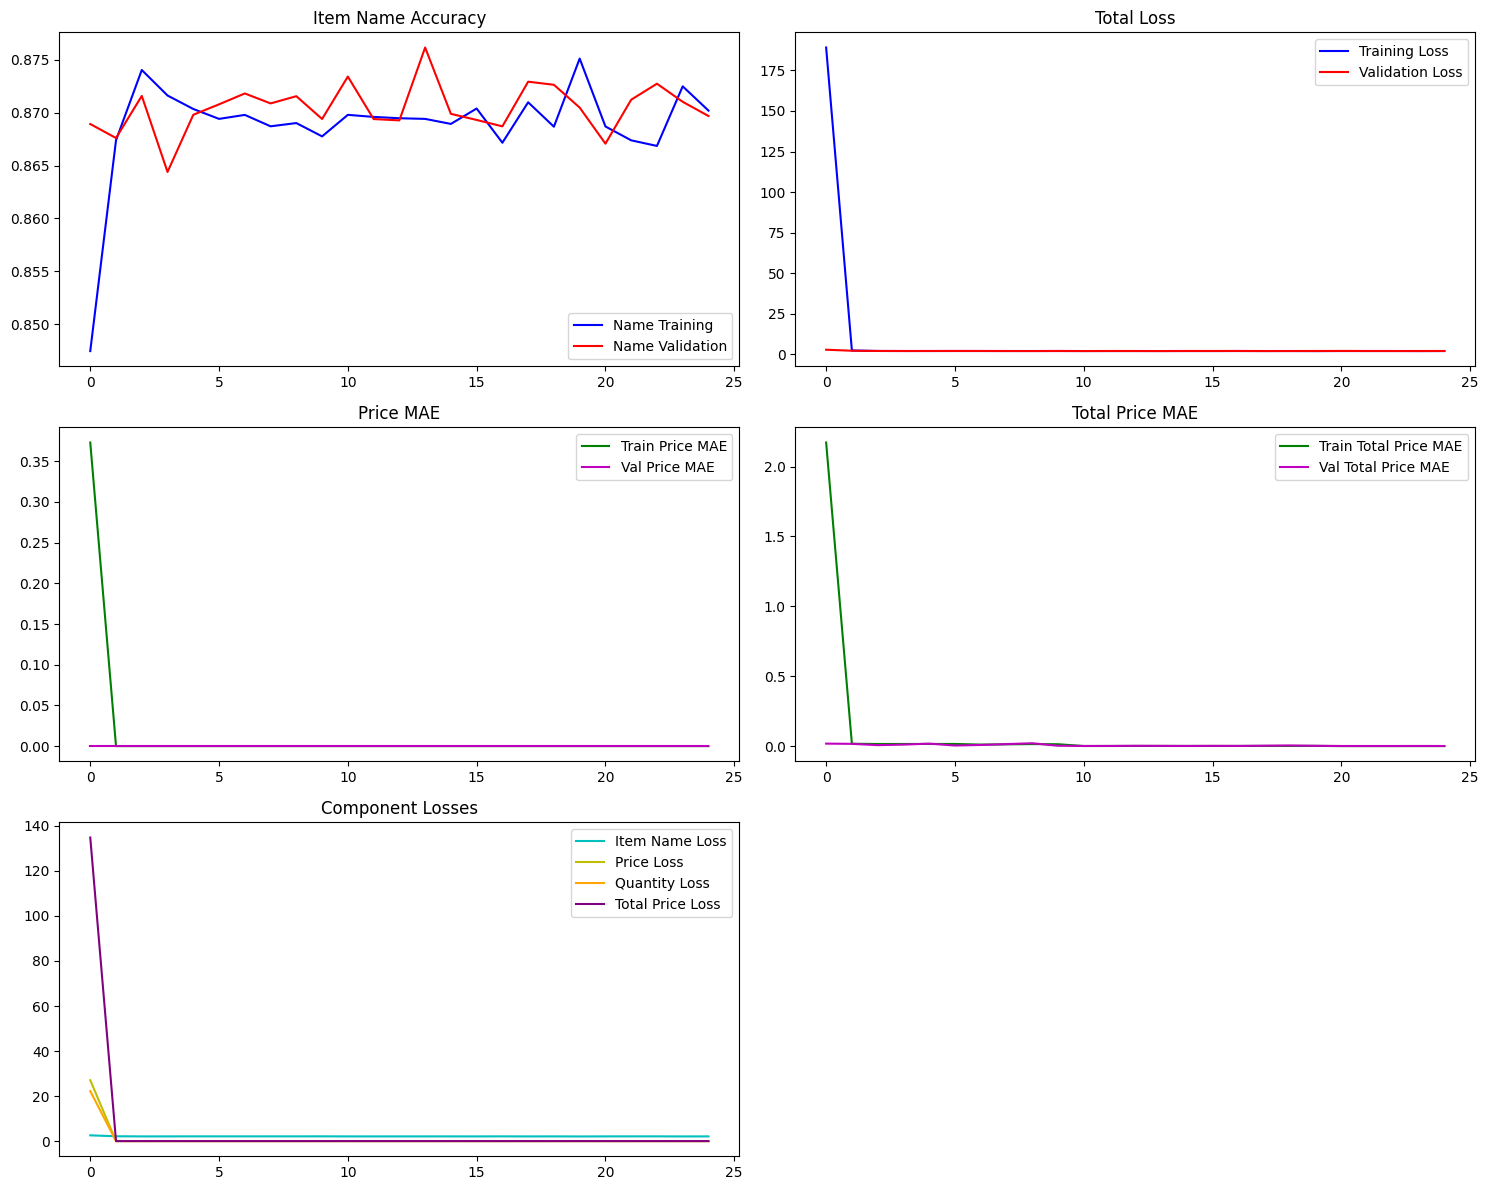

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training log
log_data = pd.read_csv("training_log.csv")

plt.figure(figsize=(15, 12))

# Plot Item Name Accuracy
plt.subplot(3, 2, 1)
plt.plot(log_data['epoch'], log_data['item_name_accuracy'], 'b-', label='Name Training')
plt.plot(log_data['epoch'], log_data['val_item_name_accuracy'], 'r-', label='Name Validation')
plt.title('Item Name Accuracy')
plt.legend()

# Plot Total Loss
plt.subplot(3, 2, 2)
plt.plot(log_data['epoch'], log_data['loss'], 'b-', label='Training Loss')
plt.plot(log_data['epoch'], log_data['val_loss'], 'r-', label='Validation Loss')
plt.title('Total Loss')
plt.legend()

# Plot Regression Performance (Price MAE)
plt.subplot(3, 2, 3)
plt.plot(log_data['epoch'], log_data['price_final_mae'], 'g-', label='Train Price MAE')
plt.plot(log_data['epoch'], log_data['val_price_final_mae'], 'm-', label='Val Price MAE')
plt.title('Price MAE')
plt.legend()

# Plot Regression Performance (Total Price MAE)
plt.subplot(3, 2, 4)
plt.plot(log_data['epoch'], log_data['total_price_mae'], 'g-', label='Train Total Price MAE')
plt.plot(log_data['epoch'], log_data['val_total_price_mae'], 'm-', label='Val Total Price MAE')
plt.title('Total Price MAE')
plt.legend()

# Plot Component Losses
plt.subplot(3, 2, 5)
plt.plot(log_data['epoch'], log_data['item_name_loss'], 'c-', label='Item Name Loss')
plt.plot(log_data['epoch'], log_data['price_final_loss'], 'y-', label='Price Loss')
plt.plot(log_data['epoch'], log_data['quantity_final_loss'], 'orange', label='Quantity Loss')
plt.plot(log_data['epoch'], log_data['total_price_loss'], 'purple', label='Total Price Loss')
plt.title('Component Losses')
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
import os

In [29]:
# Save Model
model.export("final_faster_rcnn_resnet50v2")  # Keras 3+
model.save("final_faster_rcnn_resnet50v2.h5")
model.save("final_faster_rcnn_resnet50v2.keras")
print("Model saved successfully!")

Saved artifact at 'final_faster_rcnn_resnet50v2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 600, 600, 3), dtype=tf.float32, name='image_input'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='type_input')]
Output Type:
  List[TensorSpec(shape=(None, 10, 20, 122), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  132093464379984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132093331120976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132093331123616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132093331122032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132093331122560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132093331124144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132093331127312: Te

In [32]:
# import shutil

drive_service = build('drive', 'v3')

folder_id = "1a0i_DpxSo1RnkT7ZjUr_AdawVvW2vBSX"  # Dapatkan dari URL Google Drive folder kamu

# # Zip folder SavedModel
# shutil.make_archive("final_faster_rcnn_resnet50v2", 'zip', "final_faster_rcnn_resnet50v2")

# file_metadata = {
#     "name": "final_faster_rcnn_resnet50v2",
#     "parents": [folder_id]
# }
# media_savedmodel = MediaFileUpload("final_faster_rcnn_resnet50v2", mimetype="application/octet-stream")
# file_savedmodel = drive_service.files().create(body=file_metadata_savedmodel, media_body=media_savedmodel, fields="id").execute()
# print(f"File uploaded with ID: {file_savedmodel.get('id')}")

file_metadata = {
    "name": "final_faster_rcnn_resnet50v2.keras",
    "parents": [folder_id]
}
media = MediaFileUpload("final_faster_rcnn_resnet50v2.keras", mimetype="application/octet-stream")

file = drive_service.files().create(body=file_metadata, media_body=media, fields="id").execute()
print(f"File uploaded with ID: {file.get('id')}")

file_metadata_h5 = {
    "name": "final_faster_rcnn_resnet50v2.h5",
    "parents": [folder_id]
}
media_h5 = MediaFileUpload("final_faster_rcnn_resnet50v2.h5", mimetype="application/octet-stream")

file_h5 = drive_service.files().create(body=file_metadata_h5, media_body=media_h5, fields="id").execute()
print(f"File uploaded with ID: {file_h5.get('id')}")

File uploaded with ID: 18_0GkXzdiN_1wHsXtvsL08SBstYnVWrg
File uploaded with ID: 15qzlZsvhkJ4u2JGxs_m_L0cbwMYEZTvP
